In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import sklearn.manifold
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context("poster")

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('online-retail-data.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Описание полей

InvoiceNo: номер транзакции

StockCode: код продукта

Description: описание продукта

Quantity: кол-во элементов в транзакции

InvoiceDate: дата

CustomerID: пользователь

In [3]:
# Удалим пустые значения
df.dropna(inplace=True)

In [4]:
df['StockCode'] = df['StockCode'].astype(str)

In [5]:
customers = set(df['CustomerID'])
customers = list(customers)

In [6]:
# рандомно определим наборы для обучения и теста
customers_train = random.sample(customers, (round(len(customers)*.9)))
print(len(customers_train))

train_df = df[df['CustomerID'].isin(customers_train)]
test_df = df[~df['CustomerID'].isin(customers_train)]

3935


In [7]:
# история покупок для обучающей выборки
purchases_train = []

for i in tqdm(customers_train):
    in_training = train_df[train_df['CustomerID'] == i]['StockCode'].tolist()
    purchases_train.append(in_training)

100%|████████████████████████████████████████████████████████████████████████████| 3935/3935 [00:02<00:00, 1322.42it/s]


In [8]:
# история покупок для обучающей тестовой выборки
purchases_test = []

for i in tqdm(test_df['CustomerID'].unique()):
    in_training = test_df[test_df['CustomerID'] == i]['StockCode'].tolist()
    purchases_test.append(in_training)

100%|██████████████████████████████████████████████████████████████████████████████| 437/437 [00:00<00:00, 2012.85it/s]


In [10]:
#  W2V
model = Word2Vec(window=10, sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=4)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples=model.corpus_count, epochs=10, report_delay=1)

(3591465, 3629410)

In [11]:
products = train_df[["StockCode", "Description"]]

# удалим дубликаты в данных
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# cоздадим единый словарь
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [12]:
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

### поиск схожих элементов

In [13]:
def similar_products(v, n = 6):
    
    # извлечение наиболее похожих элементов
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    
    # имена и значения схожести
    new_ms = []
    for j in ms:
        
        pair = (j, products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms   

In [14]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model.wv[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [15]:
similar_products(aggregate_vectors(purchases_test[0]))

[(('22734', 0.701832115650177),
  'SET OF 6 RIBBONS VINTAGE CHRISTMAS',
  0.701832115650177),
 (('22910', 0.694189727306366),
  'PAPER CHAIN KIT VINTAGE CHRISTMAS',
  0.694189727306366),
 (('23319', 0.6877208352088928),
  "BOX OF 6 MINI 50'S CRACKERS",
  0.6877208352088928),
 (('22950', 0.6817300915718079),
  '36 DOILIES VINTAGE CHRISTMAS',
  0.6817300915718079),
 (('22423', 0.6748690605163574),
  'REGENCY CAKESTAND 3 TIER',
  0.6748690605163574),
 (('23234', 0.6715929508209229),
  'BISCUIT TIN VINTAGE CHRISTMAS',
  0.6715929508209229)]

### Визуализация объектов

In [17]:
count = 10000
word_vectors_matrix = np.ndarray(shape=(count, 100), dtype='float64')
word_list = []
i = 0
for word in model.wv.key_to_index.keys():
    word_vectors_matrix[i] = model.wv[word]
    word_list.append(word)
    i = i+1
    if i == count:
        break
print("word_vectors_matrix shape is ", word_vectors_matrix.shape)

word_vectors_matrix shape is  (10000, 100)


In [18]:
# Создание 2Д пространства для объектов

tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
word_vectors_matrix_2d = tsne.fit_transform(word_vectors_matrix)
print("word_vectors_matrix_2d shape is ", word_vectors_matrix_2d.shape)

word_vectors_matrix_2d shape is  (10000, 2)


In [19]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1]) 
        for word, coords in [
            (word, word_vectors_matrix_2d[word_list.index(word)])
            for word in word_list
        ]
    ],
    columns=["word", "x", "y"]
)

<AxesSubplot:xlabel='x', ylabel='y'>

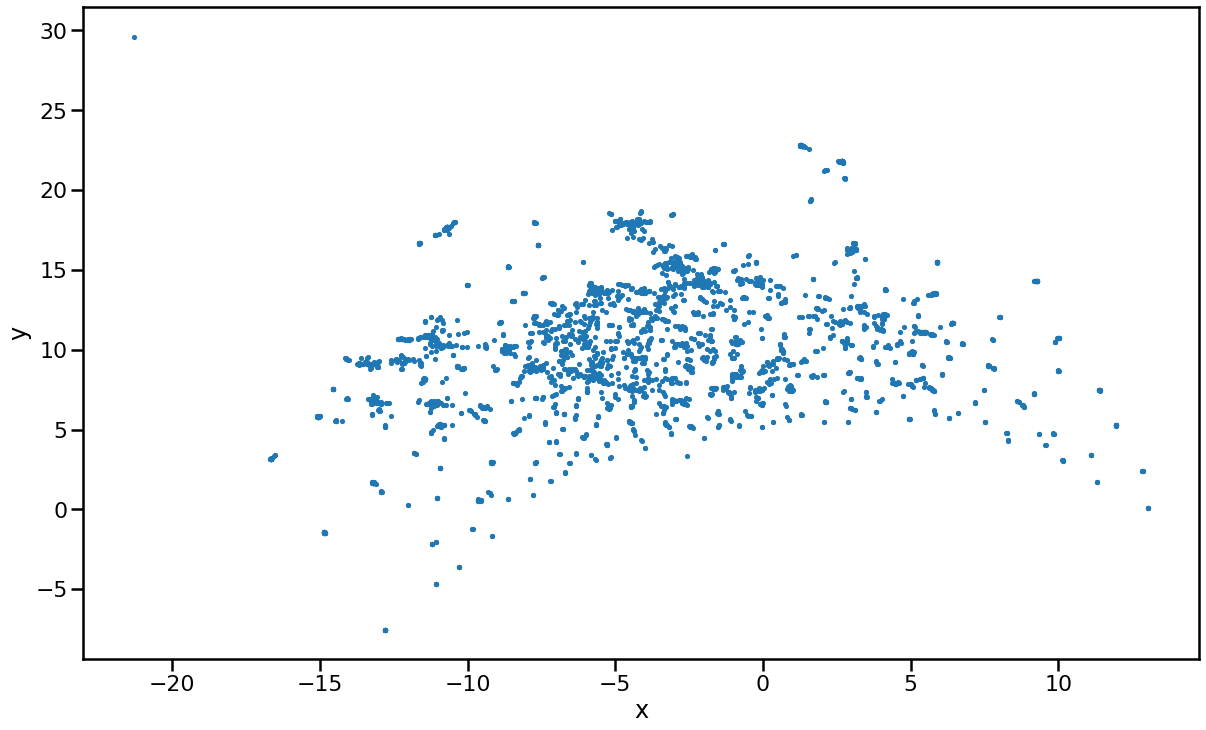

In [20]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [21]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) & (points.x <= x_bounds[1]) &
        (y_bounds[0] <= points.y) & (points.y <= y_bounds[1]) 
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(12, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

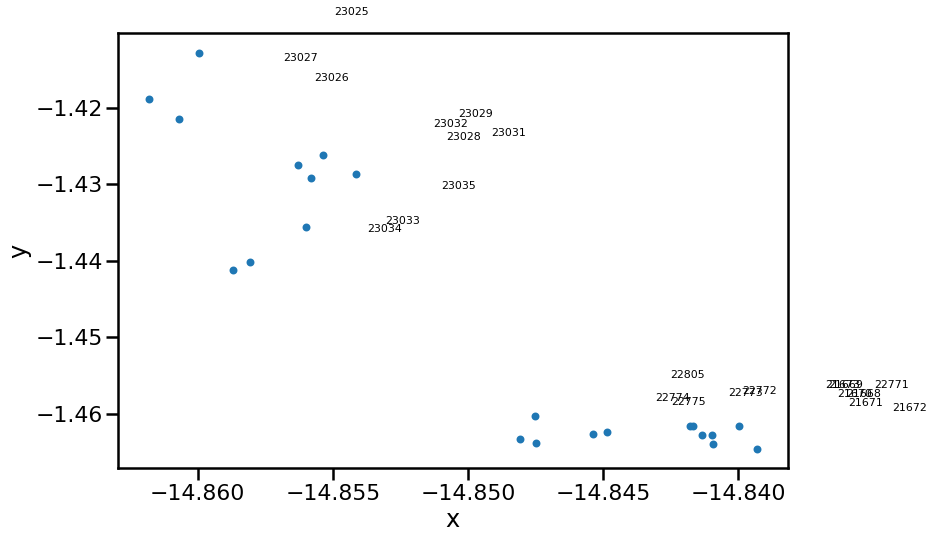

In [22]:
# вывод отдельной области элементов

# меньше / больше

plot_region(x_bounds=(-16, -14), y_bounds=(-2, 2))

In [24]:
similar_products(model.wv['23035'])

[(('23033', 0.8450888395309448),
  'DRAWER KNOB CERAMIC RED',
  0.8450888395309448),
 (('23034', 0.7352439165115356),
  'DRAWER KNOB CERAMIC BLACK',
  0.7352439165115356),
 (('23032', 0.7209578156471252),
  'DRAWER KNOB CRACKLE GLAZE IVORY',
  0.7209578156471252),
 (('23025', 0.7175209522247314),
  'DRAWER KNOB VINTAGE GLASS BALL',
  0.7175209522247314),
 (('23029', 0.7098231315612793),
  'DRAWER KNOB CRACKLE GLAZE GREEN',
  0.7098231315612793),
 (('23028', 0.7075046300888062),
  'DRAWER KNOB CRACKLE GLAZE BLUE',
  0.7075046300888062)]

### более знакомый вариант поиска схожести

In [25]:
def cosine_distance(vec1, vec2):
    return np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [26]:
def compute_similarity(model, topn=5, input_key=None, product_vec=None):
    all_similarities = []
    if not input_key and product_vec is None : return 0

    elif product_vec is None:
        product_vec = model.wv[input_key]
    
    for key, product_name in all_products.items():
        try:
            dist = cosine_distance(product_vec, model.wv[key])
            if dist != 1: all_similarities.append((product_name, dist))
        except:
            pass
        
    return sorted(all_similarities, key=lambda x: x[1], reverse=True)[:topn]

In [27]:
def seq_avg_vector(products):
    avg_vec = []
    for product in products:
        try:
            avg_vec.append(model.wv[product])
        except:
            pass
        
    return np.mean(avg_vec, axis=0)

In [30]:
def product_recommender(model, key, nb=3):
    print(f'Для продукта t "{all_products[key]}" созданы рекомендации :')
    recommendations = compute_similarity(model, input_key=key, topn=nb)
    for item in recommendations:
        print(f'\t - {item[0]}')
     

In [31]:
def sequence_recommender(model, orders_list, nb=3):
    print("Продукты покупаемые в последовательности :")
    for item in orders_list:
        print(all_products[item])
    
    print(f'\nБазируясь на истории покупок, можно создать последовательность рекомендаций :')
    recommendations = compute_similarity(model, product_vec=seq_avg_vector(orders_list), topn=nb)
    for item in recommendations:
        print(f'\t - {item[0]}')

In [32]:
all_products = df.groupby("StockCode")["Description"].unique().apply(lambda x: x[0]).to_dict()
product_recommender(model,'23256')

Для продукта t "CHILDRENS CUTLERY SPACEBOY " созданы рекомендации :
	 - CHILDRENS CUTLERY DOLLY GIRL 
	 - CHILDRENS CUTLERY CIRCUS PARADE
	 - PINK 3 PIECE POLKADOT CUTLERY SET


In [33]:
product_recommender(model,'23455')

Для продукта t "SMALL PARLOUR PICTURE FRAME" созданы рекомендации :
	 - MEDIUM PARLOUR PICTURE FRAME 
	 - LARGE PARLOUR PICTURE FRAME
	 - SET OF 3 MINI HANGING PORTRAITS
